# Activity 3.2 Bayesian Classifier
In this activity we explore a well-known generative model for classification, called **Bayesian Classifier**, to solve binary classification problems. Since we use the synthetic dataset that we generated in the Activity 3.1, we can easily validate our model assumptions by comparing the learned parameters with generator parameters.  
In Assessment 2, you are asked to expand the algorithm you have learned in this activity in order to solve multi-class classification problems.

## Dataset
First, we generate a dataset following the steps in Activity 3.1, and then we divide it into training and testing sets.

In [9]:
#install.packages('mvtnorm')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [10]:
# Data Generation
## Libraries:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

In [11]:
## Initialization
N <- 1000
c0 <- '+1'; c1 <- '-1' # class labels
mu0 <- c(4.5, 0.5); p0 <- 0.60
mu1 <- c(1.0, 4.0); p1 <- 1 - p0
sigma <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE) # shared covariance matrix
sigma0 <- sigma;   sigma1 <- sigma
### an examle of nonshared covariance matrices
#sigma0 <- matrix(c(0.2, 0.2, 0.2, 0.2), nrow=2, ncol=2, byrow = TRUE);   sigma1 <- matrix(c(1, 0, 0, 1), nrow=2, ncol=2, byrow = TRUE)

data <- data.frame(x1=double(), x2=double(), label=factor(levels = c(c0,c1))) # empty data.frame

## Generate class labels
data[1:N,'label'] <- sample(c(c0,c1), N, replace = TRUE, prob = c(p0, p1))

## calculate the size of each class
N0 <- sum(data[1:N,'label']==c0); N1 <- N - N0

## Sample from the Gaussian distribution accroding to the class labels and statitics.
data[data[1:N,'label']==c0, c('x1', 'x2')] <- rmvnorm(n = N0, mu0, sigma0)
data[data[1:N,'label']==c1, c('x1', 'x2')] <- rmvnorm(n = N1, mu1, sigma1)

In [12]:
## Split data to train and test datasets
train.len <- round(N/2)
train.index <- sample(1:N, train.len, replace = FALSE)
train.data <- data[train.index, c('x1', 'x2')]
test.data <- data[-train.index, c('x1', 'x2')]
train.label <- data[train.index, 'label']
test.label <- data[-train.index, 'label']

### Visualize The Generated Data
Let's take another look at the generated data. In the bellow figure, the black circles indicate the class means.

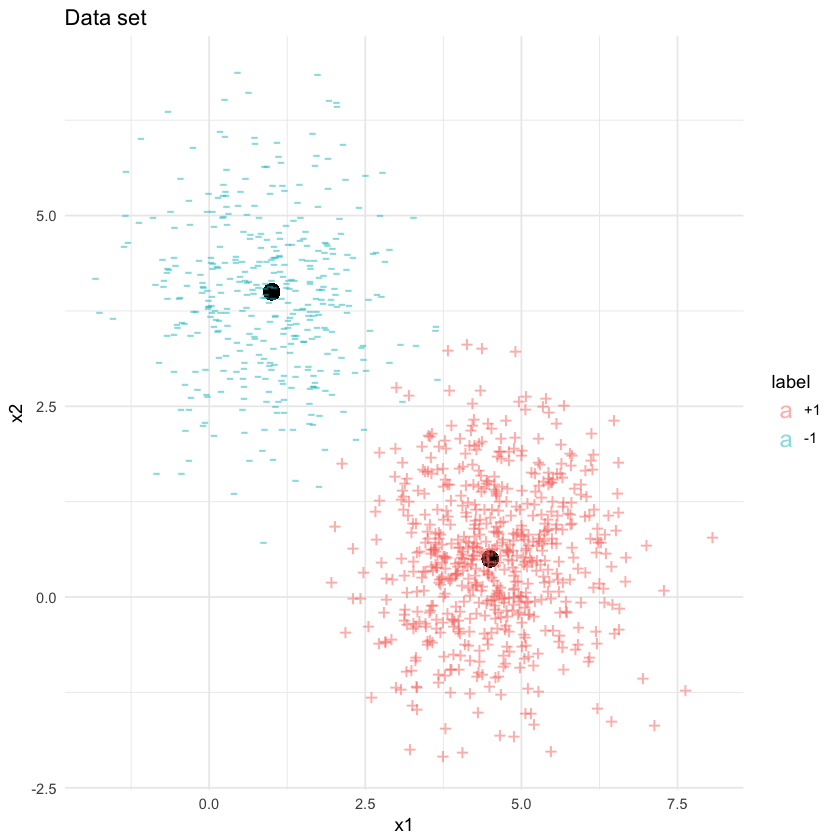

In [13]:
## Take a look at the data set
ggplot(data=data, aes(x=x1, y=x2, color=label, label=ifelse(label==c0, '+', '-'))) +
    geom_point(x=mu0[1], y=mu0[2], size=4, color = 'black') +
    geom_point(x=mu1[1], y=mu1[2], size=4, color = 'black') +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Data set') +
    theme_minimal()

---

## Bayesian Classifier 
### Steps to Build A Bayesian Classifier
These are the steps to build a bayesian Classifier:
- Calculate **the class priors** $p(\mathcal{C}_k)$ based on the relative number of training data in each class,
- Calculate **the class means** $\mu_k$, **class covariance matrices** $\mathbf{S}_k$ and **shared covariance matrix** $\Sigma$  <font color='red'>**using the training data**</font>
- Using the **estimated PDF function**, calculate $p(x_n|\mathcal{C}_k)$ for each data point and each class
- For **each** test sample, **find the class label $\mathcal{C}_k$ that maximizes the $p(\mathcal{C}_k)p(x_n|\mathcal{C}_k)$ **

In the following we take these steps one by one.

### Implementation of Bayesian Classifier
**Step 1:** Let's start with calculating the class probabilities and compare the obtained values with the real class probabilites.

**Note:** we use `.hat` notation after the name of variables to differentiate the estimations from the original (generative parameter) values. 

In [14]:
# Class probabilities:

# total number of samples in class 0 divided by the total nmber of training data
p0.hat <- sum(train.label==c0)/nrow(train.data)

# or simply 1 - p1.hat
p1.hat <- sum(train.label==c1)/nrow(train.data) 

cat(sprintf('\nThe real class probabilities:\t\t%f, %f\nThe estimated class probabilities:\t%f, %f\n', p0, p1, p0.hat, p1.hat))


The real class probabilities:		0.600000, 0.400000
The estimated class probabilities:	0.604000, 0.396000


**Step 2 (means):** Now, we estimate the class means and compare them with the real means.

In [15]:
# Class means:
mu0.hat <- colMeans(train.data[train.label==c0,])
mu1.hat <- colMeans(train.data[train.label==c1,])

cat(sprintf('\nThe real class means:\t\t%f, %f\t%f, %f\t\nThe estimated class means:\t%f, %f\t%f, %f\t\n', 
          mu0[1], mu0[2], mu1[1], mu1[2],
          mu0.hat[1], mu0.hat[2], mu1.hat[1], mu1.hat[2]))


The real class means:		4.500000, 0.500000	1.000000, 4.000000	
The estimated class means:	4.572147, 0.488166	0.837350, 3.892101	


**Step 2 (variances):** Its time to calculate class variance matrices. Based on these matrices, we can easily calculate the shared covariance matrix as it is a weighted average of the class covariance matrices.

In [16]:
# class covariance matrices:
sigma0.hat <- var(train.data[train.label==c0,])
sigma1.hat <- var(train.data[train.label==c1,])

# shared covariance matrix:
sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 

cat(sprintf('\nThe real class covariance matrix:\n\t%f, %f\n\t%f, %f\nThe estimated covariance matrix:\n\t%f, %f\n\t%f, %f\n', 
          sigma[1], sigma[2], sigma[3], sigma[4],
          sigma.hat[1], sigma.hat[2], sigma.hat[3], sigma.hat[4]))


The real class covariance matrix:
	1.000000, 0.000000
	0.000000, 1.000000
The estimated covariance matrix:
	1.007650, 0.059933
	0.059933, 0.951582


**Step 3:**  Now, we calculate the postoriors based on the estimated parameters in the above steps. 

**Note:** We can easily generate some samples using the learnt parameters. That's why Bayesian classifier is known as a generative model. As an optional actvity, try to generate some points, plot them and compare the visualizations with the original samples.

In [17]:
# calculate posteriors:
posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)

**Step 4:** To predict the class label of a data pint, we only need to compare the posteriors and assign the label which is associated with te largest posterior.

In [18]:
# calculate predictions:
train.predict <- ifelse(posterior0 > posterior1, c0, c1)
test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

# calculate accuracy:
cat(sprintf('\nTraining accuracy:\t%.2f%%', sum(train.label==train.predict)/nrow(train.data)*100))
cat(sprintf('\nTesting accuracy:\t%.2f%%', sum(test.label==test.predict)/nrow(test.data)*100))


Training accuracy:	99.80%
Testing accuracy:	99.40%

To see the performance of our classifier, let's produce two confusion matrices (one for training and the other one for testing data).

In [19]:
# Confusion Matix (Train):
table(train.label, train.predict)

# Confusion Matix (Test):
table(test.label, test.predict)

           train.predict
train.label  -1  +1
         +1   1 301
         -1 198   0

          test.predict
test.label  -1  +1
        +1   1 298
        -1 199   2

# Discussions:

1. We assumed that the classes have a common covariance matrix (model assumption). What will happen if each class has its unique covariance matrix? Repeat the activities and explain the results.

> If each class have their own covariance matrix, then there are not standard for comparison. Then cant have the confusion matrix.

2. Discuss what will happen when the class sizes are very imbalance (a very large class while the other one is very small).